In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from skimage.io import imread
import os

import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import jaccard_similarity_score as jsc

#from google.colab import files
import csv
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
### Load Dataset ###

# The data is organised in three folders: train, val and test
# Construct dataloader 
class LIDC(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./LIDC_crops/LIDC_DLCV_version'):
        'Initialization'
        self.transform = transform
        if train == 'train':
          data_path = os.path.join(data_path, 'train')
        elif train == 'val':
          data_path = os.path.join(data_path, 'val')
        else:
          data_path = os.path.join(data_path, 'test')
        print(data_path)
        # Sort the file names
        self.image_paths = sorted(glob.glob(data_path + '/images/*.png'))
        self.lesion_paths = sorted(glob.glob(data_path + '/lesions/*l1.png'))
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        lesion_path = self.lesion_paths[idx]
        lesion = Image.open(lesion_path)

        X = self.transform(image)
        #X_path = image_path
        y = self.transform(lesion)
        #y_path = lesion_path
        return X, y#, X_path, y_path

In [3]:
# Size of the images and lesions is actually 128x128
size = 128
#image_means = [0.5225563, 0.44116604, 0.358439]
#image_std = [0.2690048, 0.26258895, 0.27288762]
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                      transforms.ToTensor()])

# Remember to also normalise test set
# No augmentation of test
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = LIDC(train='train', transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
valset = LIDC(train='val', transform=test_transform)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)
testset = LIDC(train='test', transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
print(len(train_loader)*batch_size,len(val_loader)*batch_size,len(test_loader)*batch_size)

./LIDC_crops/LIDC_DLCV_version/train
./LIDC_crops/LIDC_DLCV_version/val
./LIDC_crops/LIDC_DLCV_version/test
8896 2048 1984


img shape:  torch.Size([64, 1, 128, 128])


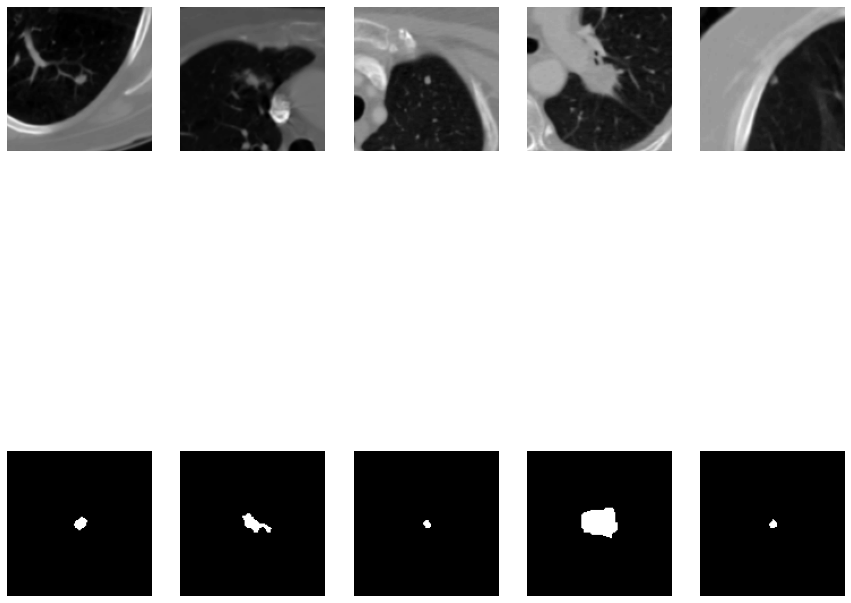

In [4]:
#images, lesions = next(iter(val_loader))
for images, lesions in val_loader:
    break
print('img shape: ',images.shape)
plt.figure(figsize=(15,15))

for i in range(5):
    img = np.swapaxes(np.swapaxes(images[15*i+1].numpy(), 0, 2), 0, 1)[:,:,0]
    les = np.swapaxes(np.swapaxes(lesions[15*i+1].numpy(), 0, 2), 0, 1)[:,:,0]
    #print(img.shape)
    plt.subplot(2,5,i+1)
    plt.imshow(img,'gray')
    plt.axis('off')
    plt.subplot(2,5,i+6)
    plt.imshow(les,'gray')
    plt.axis('off')

In [5]:
### 2. Simple segmentation network ###

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Input image has only 1 channel
        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2, padding=0)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=0)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=0)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, 
                        reduce=False)#, pos_weight=torch.Tensor([167.6677]).to(device))
            # Positive weights causes more predictions of the positive class, not improvement
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss + (1-self.alpha)*F.sigmoid(inputs)

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [7]:
## Evaluation metrics ###
# Dice overlap, Intersection over Union, Accuracy, Sensitivity, and Specificity.

# Dice overlap, 1-dice_loss
def dice(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    
    return (torch.sum(2*y_real*y_pred)+1)/(torch.sum(y_real+y_pred)+1)

# Intersection over Union
#def IoU(y_real, y_pred):
#  y_pred = F.sigmoid(y_pred)    # probabilities
#  y_pred = torch.round(y_pred)  # class
  # Covnert to np arrays of ints
#  y_real = y_real.cpu().detach().numpy().reshape(-1).astype(int)
#  y_pred = y_pred.cpu().detach().numpy().reshape(-1).astype(int) 
#  return jsc(y_real,y_pred)

# Intersection over Union
def IoU_torch(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    
    # A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    inter = torch.sum(y_real*y_pred)
    union = torch.sum(y_real+y_pred) - inter
    
    return (inter+1)/(union+1)

# Pixel-wise accuracy
def acc(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    return (1 - torch.mean(abs(y_real-y_pred)))

#Sensitivity, and Specificity
def SS(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)    # probabilities
    y_pred = torch.round(y_pred)  # class

    # Covnert to np arrays of ints
    y_real = y_real.cpu().detach().numpy().reshape(-1).astype(int)
    y_pred = y_pred.cpu().detach().numpy().reshape(-1).astype(int)

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_pred)):
        if y_real[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_real[i]!=y_pred[i]:
            FP += 1
        if y_real[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_real[i]!=y_pred[i]:
            FN += 1
    #sensitivity, recall, hit rate, or true positive rate (TPR), TP/(TP+FN)
    #specificity, selectivity or true negative rate (TNR), TN/(TN+FP)
    if (TP+FN) == 0:
        TPR = 0
    else:
        TPR = TP/(TP+FN)    # sensitivity
    if (TN+FP) == 0:
        TNR = 0
    else:
        TNR = TN/(TN+FP)    # specificity

    return (TPR, TNR)

#Sensitivity, and Specificity
def SS_torch(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)    # probabilities
    y_pred = torch.round(y_pred)  # class
    
    TP = torch.sum(y_real*y_pred).item()
    FP = torch.sum(y_pred).item() - TP
    
    # Inverse images
    y_pred_tilde = 1-y_pred
    y_real_tilde = 1-y_real
    
    TN = torch.sum(y_pred_tilde*y_real_tilde).item()
    FN = torch.sum(y_pred_tilde).item() - TN
    
    #sensitivity, recall, hit rate, or true positive rate (TPR), TP/(TP+FN)
    #specificity, selectivity or true negative rate (TNR), TN/(TN+FP)
    if (TP+FN) == 0:
        TPR = 0
    else:
        TPR = TP/(TP+FN)    # sensitivity
    if (TN+FP) == 0:
        TNR = 0
    else:
        TNR = TN/(TN+FP)    # specificity

    return (TPR, TNR)

# Function for evaluating the metrics on all three splits
def evaluate_metrics(model):
    criterion = FocalLoss(logits=True)
    
    # Dictionary with metrics returned by the function
    out_dict = {'train_loss': [],
                'val_loss': [],
                'test_loss': [],
                'train_acc': [],
                'val_acc': [],
                'test_acc': [],
                'train_dice': [],
                'val_dice': [],
                'test_dice': [],
                'train_IoU': [],
                'val_IoU': [],
                'test_IoU': [],
                'train_sensi': [],
                'val_sensi': [],
                'test_sensi': [],
                'train_speci': [],
                'val_speci': [],
                'test_speci': [],
               'train_sensi_torch': [],
                'val_sensi_torch': [],
                'test_sensi_torch': [],
                'train_speci_torch': [],
                'val_speci_torch': [],
                'test_speci_torch': []}

    ### Training set ###
    model.eval()  # Evaluation mode
    train_loss, train_dice,train_acc = [], [], []
    train_IoU, train_sensi, train_speci = [], [], []
    train_sensi_torch, train_speci_torch = [], []

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # forward
        with torch.no_grad():
            Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)

        # calculate metrics to show the user
        train_loss.append(loss.item())
        train_acc.append(acc(Y_batch, Y_pred).item())
        train_dice.append(dice(Y_batch, Y_pred).item())
        #train_IoU.append(IoU(Y_batch, Y_pred))
        train_IoU.append(IoU_torch(Y_batch, Y_pred).item())
        sensi_tmp, speci_tmp = SS(Y_batch, Y_pred)
        train_sensi.append(sensi_tmp)
        train_speci.append(speci_tmp)
        sensi_tmp_torch, speci_tmp_torch = SS_torch(Y_batch, Y_pred)
        train_sensi_torch.append(sensi_tmp_torch)
        train_speci_torch.append(speci_tmp_torch)
        
    ### Validation set ###
    model.eval()  # testing mode
    val_loss, val_dice, val_acc = [], [], []
    val_IoU, val_sensi, val_speci = [], [], []
    val_sensi_torch, val_speci_torch = [], []
    
    for X_val_batch, Y_val_batch in val_loader:
        X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)
        with torch.no_grad():
            output = model(X_val_batch)
        # Calculate evaluation metrics for the validation set
        val_loss.append(criterion(output, Y_val_batch).cpu().item())
        val_acc.append(acc(Y_val_batch, output).item())
        val_dice.append(dice(Y_val_batch, output).item())
        #val_IoU.append(IoU(Y_val_batch, output))
        val_IoU.append(IoU_torch(Y_val_batch, output).item())
        sensi_tmp, speci_tmp = SS(Y_val_batch, output)
        val_sensi.append(sensi_tmp)
        val_speci.append(speci_tmp)
        sensi_tmp_torch, speci_tmp_torch = SS_torch(Y_val_batch, output)
        val_sensi_torch.append(sensi_tmp_torch)
        val_speci_torch.append(speci_tmp_torch)
        
    ### Test set ###
    model.eval()  # testing mode
    test_loss, test_dice, test_acc = [], [], []
    test_IoU, test_sensi, test_speci = [], [], []
    test_sensi_torch, test_speci_torch = [], []
    
    for X_test_batch, Y_test_batch in test_loader:
        X_test_batch, Y_test_batch = X_test_batch.to(device), Y_test_batch.to(device)
        with torch.no_grad():
            output = model(X_test_batch)
        # Calculate evaluation metrics for the test set
        test_loss.append(criterion(output, Y_test_batch).cpu().item())
        test_acc.append(acc(Y_test_batch, output).item())
        test_dice.append(dice(Y_test_batch, output).item())
        #test_IoU.append(IoU(Y_test_batch, output))
        test_IoU.append(IoU_torch(Y_test_batch, output).item())
        sensi_tmp, speci_tmp = SS(Y_test_batch, output)
        test_sensi.append(sensi_tmp)
        test_speci.append(speci_tmp)
        sensi_tmp_torch, speci_tmp_torch = SS_torch(Y_test_batch, output)
        test_sensi_torch.append(sensi_tmp_torch)
        test_speci_torch.append(speci_tmp_torch)

        
    # Update dictionary
    out_dict['train_loss'].append(np.mean(train_loss))
    out_dict['val_loss'].append(np.mean(val_loss))
    out_dict['test_loss'].append(np.mean(test_loss))
    out_dict['train_acc'].append(np.mean(train_acc))
    out_dict['val_acc'].append(np.mean(val_acc))
    out_dict['test_acc'].append(np.mean(test_acc))
    out_dict['train_dice'].append(np.mean(train_dice))
    out_dict['val_dice'].append(np.mean(val_dice))
    out_dict['test_dice'].append(np.mean(test_dice))
    out_dict['train_IoU'].append(np.mean(train_IoU))
    out_dict['val_IoU'].append(np.mean(val_IoU))
    out_dict['test_IoU'].append(np.mean(test_IoU))
    out_dict['train_sensi'].append(np.mean(train_sensi))
    out_dict['val_sensi'].append(np.mean(val_sensi))
    out_dict['test_sensi'].append(np.mean(test_sensi))
    out_dict['train_speci'].append(np.mean(train_speci))
    out_dict['val_speci'].append(np.mean(val_speci))
    out_dict['test_speci'].append(np.mean(test_speci))
    out_dict['train_sensi_torch'].append(np.mean(train_sensi_torch))
    out_dict['val_sensi_torch'].append(np.mean(val_sensi_torch))
    out_dict['test_sensi_torch'].append(np.mean(test_sensi_torch))
    out_dict['train_speci_torch'].append(np.mean(train_speci_torch))
    out_dict['val_speci_torch'].append(np.mean(val_speci_torch))
    out_dict['test_speci_torch'].append(np.mean(test_speci_torch))
        
    return out_dict 

In [8]:
### Training function using BCE

def train_built_in_loss(model, opt, epochs, data_tr, data_val, state_str=None, state_dict=None, alpha=1):
    #X_plot, Y_plot = next(iter(data_val))
    for X_plot, Y_plot in val_loader:
        break
    
    #pos_weight = 50*torch.ones([128])
    #criterion = torch.nn.BCEWithLogitsLoss()#pos_weight=pos_weight)
    criterion = FocalLoss(logits=True, alpha=alpha)

    # Dictionary with metrics returned by the function
    out_dict = {'train_acc': [],
              'val_acc': [],
              'train_loss': [],
              'val_loss': [],
              'train_dice': [],
              'val_dice': [],
              'train_IoU': [],
              'val_IoU': [],
              'train_sensi': [],
              'val_sensi': [],
              'train_speci': [],
              'val_speci':[]}
    
    # Load dictionary
    #out_dict = np.load('epoch_dict.npy',allow_pickle='TRUE').item()
    # Load model
    #model.load_state_dict(torch.load('epoch_model.pth'))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        ### Training ###
        train_loss, train_dice,train_acc = [], [], []
        train_IoU, train_sensi, train_speci = [], [], []
        
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
            train_loss.append(loss.item())
            train_acc.append(acc(Y_batch, Y_pred).item())
            train_dice.append(dice(Y_batch, Y_pred).item())
            train_IoU.append(IoU_torch(Y_batch, Y_pred).item())
            sensi_tmp, speci_tmp = SS_torch(Y_batch, Y_pred)
            train_sensi.append(sensi_tmp)
            train_speci.append(speci_tmp)
            
        toc = time()
        print(' - loss: %f' % avg_loss)
        
        ### Validation ###
        model.eval()  # testing mode
        val_loss, val_dice, val_acc = [], [], []
        val_IoU, val_sensi, val_speci = [], [], []
        
        for X_val_batch, Y_val_batch in data_val:
            X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)
            with torch.no_grad():
                output = model(X_val_batch)
            # Calculate evaluation metrics for the validation set
            val_loss.append(criterion(output, Y_val_batch).cpu().item())
            val_acc.append(acc(Y_val_batch, output).item())
            val_dice.append(dice(Y_val_batch, output).item())
            val_IoU.append(IoU_torch(Y_val_batch, output).item())
            sensi_tmp, speci_tmp = SS_torch(Y_val_batch, output)
            val_sensi.append(sensi_tmp)
            val_speci.append(speci_tmp)

        # show intermediate results
        Y_hat = F.sigmoid(model(X_plot.to(device))).detach().cpu()
        clear_output(wait=True)
        print('X: ', X_plot.shape, 'Y_plot: ', Y_plot.shape, 'Y_hat: ', Y_hat.shape)
        plt.figure(figsize=(15,15))
        for k in range(5):
            plt.subplot(3, 5, k+1)
            plt.imshow(np.rollaxis(X_plot[15*k+1].numpy(), 0, 3)[:,:,0], cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 5, k+6)
            plt.imshow(Y_hat[15*k+1, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 5, k+11)
            plt.imshow(Y_plot[15*k+1, 0], cmap='gray')
            plt.title('Annotation')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
        # Update dictionary
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['val_loss'].append(np.mean(val_loss))
        out_dict['train_dice'].append(np.mean(train_dice))
        out_dict['val_dice'].append(np.mean(val_dice))
        out_dict['train_acc'].append(np.mean(train_acc))
        out_dict['val_acc'].append(np.mean(val_acc))
        out_dict['train_IoU'].append(np.mean(train_IoU))
        out_dict['val_IoU'].append(np.mean(val_IoU))
        out_dict['train_sensi'].append(np.mean(train_sensi))
        out_dict['val_sensi'].append(np.mean(val_sensi))
        out_dict['train_speci'].append(np.mean(train_speci))
        out_dict['val_speci'].append(np.mean(val_speci))
        
        # Save intermediate model and dictionary
        #if epoch % 10 == 0:
            # Save the current state of the model
        #    torch.save(model.state_dict(), 'epoch_model.pth')
            # Save the dictionary
        #    np.save('epoch_dict.npy', out_dict)  # Using numpy
        
    return out_dict

In [9]:
torch.cuda.empty_cache()
model = SegNet().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
         MaxPool2d-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
         Upsample-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
         Upsample-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
         Upsample-14           [-1, 64,

In [10]:
# Save the current state of the model
#torch.save(model.state_dict(), 'seg_model.pth')

# Save the dictionary
#np.save('seg_dict.npy', seg_dict)  # Using numpy
#def save_obj(seg_dict, 'seg_dict' ): # Using pickle
#    with open('obj/'+ name + '.pkl', 'wb') as f:
#        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
# Load dictionary
#seg_dict = np.load('seg_dict.npy',allow_pickle='TRUE').item()
#def load_obj(name ):
#    with open('obj/' + name + '.pkl', 'rb') as f:
#        return pickle.load(f)

# Load model
#model_load.load_state_dict(torch.load('seg_model.pth'))

In [12]:
### Plot of the evaluation metrics ###
'''
# Plot the loss (cross entropy)
plt.figure()
plt.plot(seg_dict['train_loss'], 'r', seg_dict['val_loss'], 'b')
plt.legend(['Train loss - SegNet','Test loss - SegNet'])
plt.xlabel('Epoch number'), plt.ylabel('Loss')

# Accuracy
plt.figure()
plt.plot(seg_dict['train_acc'], 'r', seg_dict['val_acc'], 'b')
plt.legend(['Train acc - SegNet','Val acc - SegNet'])
plt.xlabel('Epoch number'), plt.ylabel('Accuracy')

# Dice overlap
plt.figure()
plt.plot(seg_dict['train_dice'], 'r', seg_dict['val_dice'], 'b')
plt.legend(['Train dice - SegNet','Test dice - SegNet'])
plt.xlabel('Epoch number'), plt.ylabel('Dice overlap')

# Intersection over Union
plt.figure()
plt.plot(seg_dict['train_IoU'], 'r', seg_dict['val_IoU'], 'b')
plt.legend(['Train IoU - SegNet','Test IoU - SegNet'])
plt.xlabel('Epoch number'), plt.ylabel('Intersection over Union')

# Sensitivity and Specificity
plt.figure()
plt.plot(seg_dict['train_sensi'], 'r', seg_dict['val_sensi'], 'b')
plt.plot(seg_dict['train_speci'], 'g', seg_dict['val_speci'], 'm')
plt.legend(['Train sensitivity - SegNet','Test sensitivity - SegNet', 
            'Train specificity - SegNet','Test specificity - SegNet',])
plt.xlabel('Epoch number'), plt.ylabel('Sensitivity and specificity')
'''

"\n# Plot the loss (cross entropy)\nplt.figure()\nplt.plot(seg_dict['train_loss'], 'r', seg_dict['val_loss'], 'b')\nplt.legend(['Train loss - SegNet','Test loss - SegNet'])\nplt.xlabel('Epoch number'), plt.ylabel('Loss')\n\n# Accuracy\nplt.figure()\nplt.plot(seg_dict['train_acc'], 'r', seg_dict['val_acc'], 'b')\nplt.legend(['Train acc - SegNet','Val acc - SegNet'])\nplt.xlabel('Epoch number'), plt.ylabel('Accuracy')\n\n# Dice overlap\nplt.figure()\nplt.plot(seg_dict['train_dice'], 'r', seg_dict['val_dice'], 'b')\nplt.legend(['Train dice - SegNet','Test dice - SegNet'])\nplt.xlabel('Epoch number'), plt.ylabel('Dice overlap')\n\n# Intersection over Union\nplt.figure()\nplt.plot(seg_dict['train_IoU'], 'r', seg_dict['val_IoU'], 'b')\nplt.legend(['Train IoU - SegNet','Test IoU - SegNet'])\nplt.xlabel('Epoch number'), plt.ylabel('Intersection over Union')\n\n# Sensitivity and Specificity\nplt.figure()\nplt.plot(seg_dict['train_sensi'], 'r', seg_dict['val_sensi'], 'b')\nplt.plot(seg_dict['tra

In [13]:
### 3. U-net ###

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Input has only one input channel
        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2, padding=0)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=0)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=0)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e00 = F.relu(self.enc_conv0(x))      # 128x128
        e0 = self.pool0(e00)         # 64x64
        e11 = self.enc_conv1(e0)
        e1 = self.pool1(F.relu(e11)) # 32x32
        e22 = self.enc_conv2(e1)
        e2 = self.pool2(F.relu(e22)) # 16x16
        e33 = self.enc_conv3(e2)
        e3 = self.pool3(F.relu(e33)) # 8x8

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))  # 8x8

        # decoder
        # Introduce skip connections
        d00 = self.upsample0(b)          # 16x16
        #print('d00: ',d00.shape, 'e33:', e33.shape)
        d00_cat = torch.cat([d00, e33], 1)
        #print('cat: ',d00_cat.shape)
        d0 = F.relu(self.dec_conv0(d00_cat)) # 16x16

        d11 = self.upsample1(d0)
        #print('d11: ',d11.shape, 'e22:', e22.shape)
        d11_cat = torch.cat([d11, e22], 1)
        #print('cat: ',d11_cat.shape)
        d1 = F.relu(self.dec_conv1(d11_cat)) # 32x32
        
        d22= self.upsample2(d1)
        #print('d22: ',d22.shape, 'e11:', e11.shape)
        d22_cat = torch.cat([d22, e11], 1)
        #print('cat: ',d22_cat.shape)
        d2 = F.relu(self.dec_conv2(d22_cat)) # 64x64

        d33 = self.upsample3(d2)
        #print('d33: ',d33.shape, 'e00:', e00.shape)
        d33_cat = torch.cat([d33, e00], 1)
        #print('cat: ',d33_cat.shape)
        d3 = self.dec_conv3(d33_cat)  # no activation
        return d3

In [14]:
### 3. U-net ###
class UNet_new(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Input has only one input channel
        self.enc_conv0 = nn.Conv2d(1, 8, 3, padding=1)
        self.enc_bnorm0 = nn.BatchNorm2d(8)
        self.pool0 = nn.MaxPool2d(2, 2, padding=0)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(8, 16, 3, padding=1)
        self.enc_bnorm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.enc_bnorm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2, padding=0)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_bnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2, padding=0)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_bnorm = nn.BatchNorm2d(128)

        # decoder (upsampling)
        #self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.upsample0 = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_bnorm0 = nn.BatchNorm2d(64)
        #self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.upsample1 = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=0)
        self.dec_conv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_bnorm1 = nn.BatchNorm2d(32)
        #self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(32, 16, 2, stride=2, padding=0)
        self.dec_conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.dec_bnorm2 = nn.BatchNorm2d(16)
        #self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(16, 8, 2, stride=2, padding=0)
        self.dec_conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.dec_bnorm3 = nn.BatchNorm2d(8)
        self.dec_conv4 = nn.Conv2d(8, 1, 1, padding=0)

    def forward(self, x):
        # encoder
        e00 = F.relu(self.enc_bnorm0(self.enc_conv0(x)))      # 128x128
        e0 = self.pool0(e00)         # 64x64
        e11 = self.enc_bnorm1(self.enc_conv1(e0))
        e1 = self.pool1(F.relu(e11)) # 32x32
        e22 = self.enc_bnorm2(self.enc_conv2(e1))
        e2 = self.pool2(F.relu(e22)) # 16x16
        e33 = self.enc_bnorm3(self.enc_conv3(e2))
        e3 = self.pool3(F.relu(e33)) # 8x8

        # bottleneck
        b = F.relu(self.bn_bnorm(self.bottleneck_conv(e3)))  # 8x8

        # decoder
        # Introduce skip connections
        d00 = self.upsample0(b)          # 16x16
        #print('d00: ',d00.shape, 'e33:', e33.shape)
        d00_cat = torch.cat([d00, e33], 1)
        #print('cat: ',d00_cat.shape)
        d0 = F.relu(self.dec_bnorm0(self.dec_conv0(d00_cat))) # 16x16

        d11 = self.upsample1(d0)
        #print('d11: ',d11.shape, 'e22:', e22.shape)
        d11_cat = torch.cat([d11, e22], 1)
        #print('cat: ',d11_cat.shape)
        d1 = F.relu(self.dec_bnorm1(self.dec_conv1(d11_cat))) # 32x32
        
        d22= self.upsample2(d1)
        #print('d22: ',d22.shape, 'e11:', e11.shape)
        d22_cat = torch.cat([d22, e11], 1)
        #print('cat: ',d22_cat.shape)
        d2 = F.relu(self.dec_bnorm2(self.dec_conv2(d22_cat))) # 64x64

        d33 = self.upsample3(d2)
        #print('d33: ',d33.shape, 'e00:', e00.shape)
        d33_cat = torch.cat([d33, e00], 1)
        #print('cat: ',d33_cat.shape)
        d3 = F.relu(self.dec_bnorm3(self.dec_conv3(d33_cat)))
        d4 = self.dec_conv4(d3)
        return d4

In [15]:
model = UNet().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
         MaxPool2d-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
         Upsample-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          73,792
         Upsample-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          73,792
         Upsample-14           [-1, 64,

In [16]:
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
         MaxPool2d-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
         Upsample-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          73,792
         Upsample-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          73,792
         Upsample-14           [-1, 64,

X:  torch.Size([64, 1, 128, 128]) Y_plot:  torch.Size([64, 1, 128, 128]) Y_hat:  torch.Size([64, 1, 128, 128])


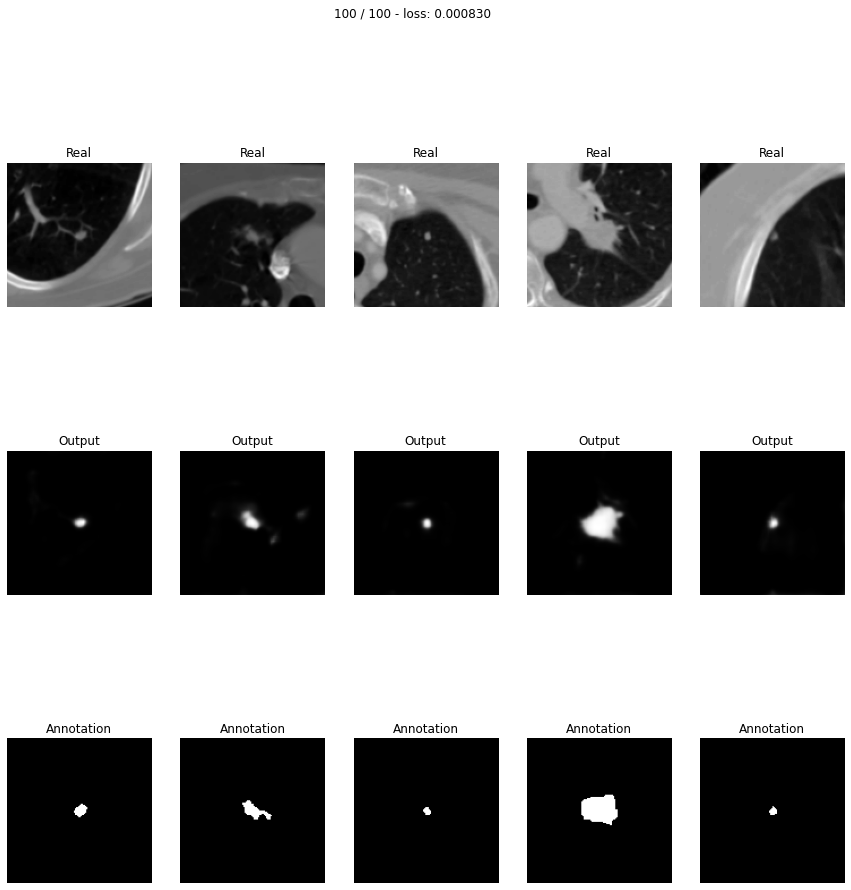

In [17]:
# Results in report: 5
# Segnet
# Unet + pos weigth + alpha=0.9
# Unet_new alpha=0.9

torch.cuda.empty_cache()
#model = SegNet().to(device)
model = UNet().to(device)
#model = UNet_new().to(device)

epochs = 100 # seems to not overfit there
new_dict = train_built_in_loss(model, optim.Adam(model.parameters(), lr=0.0001), epochs, 
                               train_loader, val_loader, alpha=1)

# Save the current state of the model
#torch.save(model.state_dict(), '.pth')

# Save the dictionary
#np.save('Unet_dict.npy', seg_dict)  # Using numpy

In [18]:
metric_dict = evaluate_metrics(model)
metric_dict

{'train_loss': [0.0007887772982102557],
 'val_loss': [0.005233697203038901],
 'test_loss': [0.007285505112621092],
 'train_acc': [0.9950090389457538],
 'val_acc': [0.9937004242092371],
 'test_acc': [0.9932262762900321],
 'train_dice': [0.6342895043839654],
 'val_dice': [0.38799282400577795],
 'test_dice': [0.3450520391305608],
 'train_IoU': [0.46561342434917424],
 'val_IoU': [0.25433703970338684],
 'test_IoU': [0.22235745488996467],
 'train_sensi': [0.8574932939242482],
 'val_sensi': [0.5440296141055093],
 'test_sensi': [0.46447908602757665],
 'train_speci': [0.9995917856437304],
 'val_speci': [0.998678382476201],
 'test_speci': [0.9982721466754544],
 'train_sensi_torch': [0.8574932939242482],
 'val_sensi_torch': [0.5440296141055093],
 'test_sensi_torch': [0.46447908602757665],
 'train_speci_torch': [0.9995917856437304],
 'val_speci_torch': [0.998678382476201],
 'test_speci_torch': [0.9982721466754544]}

In [19]:
# Save the current state of the model
#torch.save(model.state_dict(), 'Unet_model.pth')

# Save the dictionary
#np.save('Unet_dict.npy', seg_dict)  # Using numpy

In [20]:
# Load dictionary
#unet_dict = np.load('unet_dict_100.npy',allow_pickle='TRUE').item()
#def load_obj(name ):
#    with open('obj/' + name + '.pkl', 'rb') as f:
#        return pickle.load(f)

# Load model
#model.load_state_dict(torch.load('unet_model_100.pth'))

In [21]:
'''
# Learning currves for loss
plt.figure()
plt.plot(new_dict['train_loss'], 'r', new_dict['val_loss'], 'b')
plt.legend(['Train loss - Segnet','Val loss - Segnet'])
plt.xlabel('Epoch number'), plt.ylabel('Loss')
'''

"\n# Learning currves for loss\nplt.figure()\nplt.plot(new_dict['train_loss'], 'r', new_dict['val_loss'], 'b')\nplt.legend(['Train loss - Segnet','Val loss - Segnet'])\nplt.xlabel('Epoch number'), plt.ylabel('Loss')\n"

In [22]:
'''
unet_dice_train = []
for dloss in unet_dict['train_dice']:
    unet_dice_train.append(1-dloss)

unet_dice_val = []
for dloss in unet_dict['val_dice']:
    unet_dice_val.append(1-dloss)

plt.figure()
plt.plot(unet_dice_train, 'r', unet_dice_val, 'b')
plt.legend(['Train dice - Unet','Val dice - Unet'])
plt.xlabel('Epoch number'), plt.ylabel('Dice overlap')
'''

"\nunet_dice_train = []\nfor dloss in unet_dict['train_dice']:\n    unet_dice_train.append(1-dloss)\n\nunet_dice_val = []\nfor dloss in unet_dict['val_dice']:\n    unet_dice_val.append(1-dloss)\n\nplt.figure()\nplt.plot(unet_dice_train, 'r', unet_dice_val, 'b')\nplt.legend(['Train dice - Unet','Val dice - Unet'])\nplt.xlabel('Epoch number'), plt.ylabel('Dice overlap')\n"

In [23]:
unet_dict=new_dict

(Text(0.5, 0, 'Epoch number'), Text(0, 0.5, 'Sensitivity and specificity'))

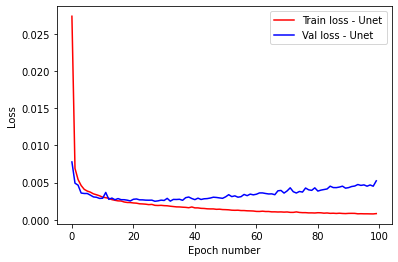

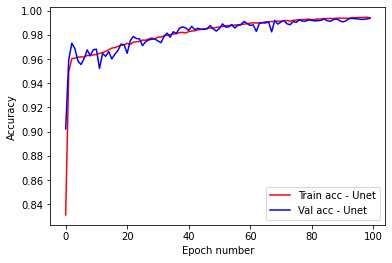

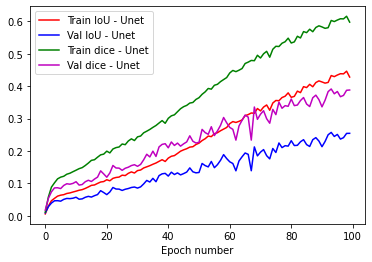

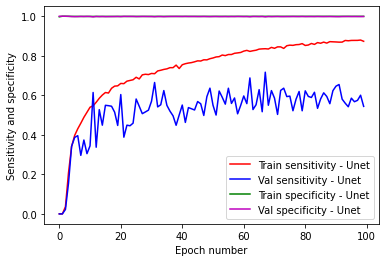

In [27]:
### Plot of the evaluation metrics ###
# Plot the loss (cross entropy)
plt.figure()
plt.plot(unet_dict['train_loss'], 'r', unet_dict['val_loss'], 'b')
plt.legend(['Train loss - Unet','Val loss - Unet'])
plt.xlabel('Epoch number'), plt.ylabel('Loss')

# Accuracy
plt.figure()
plt.plot(unet_dict['train_acc'], 'r', unet_dict['val_acc'], 'b')
plt.legend(['Train acc - Unet','Val acc - Unet'])
plt.xlabel('Epoch number'), plt.ylabel('Accuracy')

# Dice overlap
#plt.figure()
#plt.plot(unet_dict['train_dice'], 'r', unet_dict['val_dice'], 'b')
#plt.legend(['Train dice - Unet','Val dice - Unet'])
#plt.xlabel('Epoch number'), plt.ylabel('Dice overlap')

# Intersection over Union
#plt.figure()
#plt.plot(unet_dict['train_IoU'], 'r', unet_dict['val_IoU'], 'b')
#plt.legend(['Train IoU - Unet','Val IoU - Unet'])
#plt.xlabel('Epoch number'), plt.ylabel('Intersection over Union')

# Dice and IoU in one figure to save space
plt.figure()
plt.plot(unet_dict['train_IoU'], 'r', unet_dict['val_IoU'], 'b')
plt.plot(unet_dict['train_dice'], 'g', unet_dict['val_dice'], 'm')
plt.legend(['Train IoU - Unet','Val IoU - Unet',
           'Train dice - Unet','Val dice - Unet'])
plt.xlabel('Epoch number')

# Sensitivity and Specificity
plt.figure()
plt.plot(unet_dict['train_sensi'], 'r', unet_dict['val_sensi'], 'b')
plt.plot(unet_dict['train_speci'], 'g', unet_dict['val_speci'], 'm')
plt.legend(['Train sensitivity - Unet','Val sensitivity - Unet', 
            'Train specificity - Unet','Val specificity - Unet',])
plt.xlabel('Epoch number'), plt.ylabel('Sensitivity and specificity')
